# Channel quality analyzer 16 02 2021
## Structure:
1. Upload libraries 

2. Define functions

3. Load data

4. Chose relevant data that includes only sweap parameters

5. Calculate higher momenta  (around 2-3 min) and plot kurtosis - skew plots for channel 0,3,4,7

6. For a chosen channel find min, max $\mu$ and estimate min max $\sigma$ so that the data for ML produces 50% bi and unimodal distributions. Histogram parameters are as same as for real data.

7. Train the network for a given data set.

8. Use the network to classify the real histogram. 0-bimodal, 1- uni


# Zero test

In [566]:
# Upload libraries
%reload_ext autoreload
%autoreload 2

import sys; sys.path.append(r'../src');
import spiplot
from spi_results import spi_results, list_db, load_db
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# LaTeX fonts
import matplotlib
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]);

magic = 1405

#neural network
import numpy as np
import scipy.special as sps
import matplotlib.pyplot as plt
from numpy import random
import tensorflow as tf
from tensorflow import keras

In [560]:
# Define functions
def getKurt(values,counts,threshold=5):
    # Calculates Kurtosis for a given histogram:
    # values - bin centers; 
    # counts - total instances in a bin; 
    # threshold - dimensionless value (initial 5) to filter out outliers through abs deviation (not to distort higher momentums)
    
    counts = np.array(counts/np.sum(counts))
    avg = np.dot(counts,values)

    meanabs = np.dot(counts,abs(values-avg))
    indtokeep = [i for i in range(len(values)) if abs(values[i]-avg)<meanabs*threshold]
    values = [values[i] for i in indtokeep]
    counts = [counts[i] for i in indtokeep]
    
    sumcounts = np.sum(counts)
    if sumcounts==0:
        return magic
    counts = np.array(counts/sumcounts)
    avg = np.dot(counts,values)

    std = np.sqrt(np.dot(counts, (values-avg)**2))
    if std==0:
        return magic
    avg4 = np.dot(counts, (values-avg)**4)
    kur = avg4/(std**4)-3
    
    return kur

def getSkew(values,counts,threshold=5):
    # Calculates Skewness for a given histogram:
    # values - bin centers; 
    # counts - total instances in a bin; 
    # threshold - dimensionless value (initial 5) to filter out outliers through abs deviation (not to distort higher momentums)
    
    counts = np.array(counts/np.sum(counts))
    avg = np.dot(counts,values)

    meanabs = np.dot(counts,abs(values-avg))
    indtokeep = [i for i in range(len(values)) if abs(values[i]-avg)<meanabs*threshold]
    values = [values[i] for i in indtokeep]
    counts = [counts[i] for i in indtokeep]
    
    sumcounts = np.sum(counts)
    if sumcounts==0:
        return magic
    counts = np.array(counts/sumcounts)
    avg = np.dot(counts,values)

    std = np.sqrt(np.dot(counts, (values-avg)**2))
    if std==0:
        return magic

    avg3 = np.dot(counts, (values-avg)**3)
    return avg3/(std**3)



def uni(mu1,mu2,sig1,sig2,p):
#Labels for mixed gaussian distribution: 1- unimodal; 0- bimodal
    d = 0.5*abs(mu1-mu2)/np.sqrt(sig1*sig2)
    if d<=1:
        return 1
    elif abs(np.log(1-p)-np.log(p)) >=2*np.log(d-np.sqrt(d**2-1))+2*d*np.sqrt(d**2-1):
        return 1
    else:
        return 0


In [561]:
# Load data

# #01 02 2021
# hdf = 'eqrun_gini_201122'
# session_num = 54803975

# ##28 01 2021
# hdf = 'eqrun_gini_201122'
# session_num = 14650946

# 16 02 2021
hdf = 'eqrun_jane_210201'
session_num = 65296901

results = load_db( session_num, hdf+'.h5')
sw = results.df_meta['swept_params']

#results.df_meta.info()
###############################################
print(' ')
print(results.df_meta['static_params'][0])
print(' ')
print(results.df.info())
print(' ')
print(sw.values[0])
print(' ')
print(results.df.columns)

...reading 65296901 from dbfile: ../../Dropbox (Equal1)/eqrun_data/hdf/eqrun_jane_210201.h5
DONE
 
Description=zero test for QEC 207 , python_file=zero_test.ipynb , sn=A2 , Temperature=3.1 , Vimp=0.1 , sqf_file=zero_test.sqf , adc_channel=ch0 ch3 ch4 ch7 , nsamples=1000 , bin_width=0.01 , bin_range=half , 
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294872 entries, 0 to 294871
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Temperature              294872 non-null  float64       
 1   Vrd                      294872 non-null  float64       
 2   Vrg                      294872 non-null  float64       
 3   Vimp                     294872 non-null  float64       
 4   loop                     294872 non-null  float64       
 5   nsamples                 294872 non-null  float64       
 6   bin_width                294872 non-null  float64       
 7   testnum         

In [574]:
# Chose relevant data
data = results.df
# data = results.df.iloc[:, [1,8,9,17,16,12]]
data = results.df[['Vrd','Vrg','loop', 'Vanop', 'Vanop0_hist',  'Vanop3_hist','Vanop4_hist', 'Vanop7_hist']]
# data.reset_index(drop=True, inplace=True) #  reset row indices
data.head()

,Vrd,Vrg,loop,Vanop,Vanop0_hist,Vanop3_hist,Vanop4_hist,Vanop7_hist
0,-0.5,0.0,1.0,-0.407090,0.0,0.0,0.0,0.0
1,-0.5,0.0,1.0,-0.399652,0.0,0.0,0.0,0.0
2,-0.5,0.0,1.0,-0.392213,0.0,0.0,0.0,0.0
3,-0.5,0.0,1.0,-0.384775,0.0,0.0,0.0,0.0
4,-0.5,0.0,1.0,-0.377336,0.0,0.0,0.0,0.0


In [576]:
## Calculate higher momenta  2-3 min
threshold = 5;
Vanop  = np.unique((data.Vanop))
unique_parms = data.iloc[:, [0,1,2]].drop_duplicates()
points = int (len(data)/len(unique_parms))

moments = pd.DataFrame(columns=('VRD', 'VRG', 'LOOP', 'SKW0', 'SKW3', 
                                'SKW4', 'SKW7', 'KUR0', 'KUR3', 'KUR4', 'KUR7')) 
Nhisto = len(unique_parms)
# Nhisto=10
Nbins = len(Vanop)

histograms0 = np.zeros((Nhisto,Nbins))
histograms3 = np.zeros((Nhisto,Nbins))
histograms4 = np.zeros((Nhisto,Nbins))
histograms7 = np.zeros((Nhisto,Nbins))

now = time.time()
for k in range(Nhisto):
    sub =data.iloc[k*points:(k+1)*points, :]
    skw0 = getSkew(Vanop,sub['Vanop0_hist'],threshold) 
    skw3 = getSkew(Vanop,sub['Vanop3_hist'],threshold) 
    skw4 = getSkew(Vanop,sub['Vanop4_hist'],threshold) 
    skw7 = getSkew(Vanop,sub['Vanop7_hist'],threshold) 
    
    kur0 = getKurt(Vanop,sub['Vanop0_hist'],threshold) 
    kur3 = getKurt(Vanop,sub['Vanop3_hist'],threshold) 
    kur4 = getKurt(Vanop,sub['Vanop4_hist'],threshold) 
    kur7 = getKurt(Vanop,sub['Vanop7_hist'],threshold) 
    
    moments.loc[k] = [sub.iloc[0][0], sub.iloc[0][1], sub.iloc[0][2],
                     skw0, skw3, skw4, skw7, kur0, kur3, kur4, kur7]
    histograms0[k,:] = np.array(sub['Vanop0_hist'])/np.sum(np.array(sub['Vanop0_hist']))
    histograms3[k,:] = np.array(sub['Vanop3_hist'])/np.sum(np.array(sub['Vanop3_hist']))
    histograms4[k,:] = np.array(sub['Vanop4_hist'])/np.sum(np.array(sub['Vanop4_hist']))
    histograms7[k,:] = np.array(sub['Vanop7_hist'])/np.sum(np.array(sub['Vanop7_hist']))
    
later = time.time()
difference = int(later - now)
print('Total time is '+str(difference) + ' sec')
    

Total time is 13 sec


In [577]:
# remove empty data  
idx = moments[(moments.SKW0 != magic)].index
k0 = [ moments.KUR0[i] for i in idx] 
s0 = [ moments.SKW0[i] for i in idx] 

idx = moments[(moments.SKW3 != magic)].index
k3 = [ moments.KUR3[i] for i in idx] 
s3 = [ moments.SKW3[i] for i in idx] 

idx = moments[(moments.SKW4 != magic)].index
k4 = [ moments.KUR4[i] for i in idx] 
s4 = [ moments.SKW4[i] for i in idx] 

idx = moments[(moments.SKW7 != magic)].index
k7 = [ moments.KUR7[i] for i in idx] 
s7 = [ moments.SKW7[i] for i in idx] 

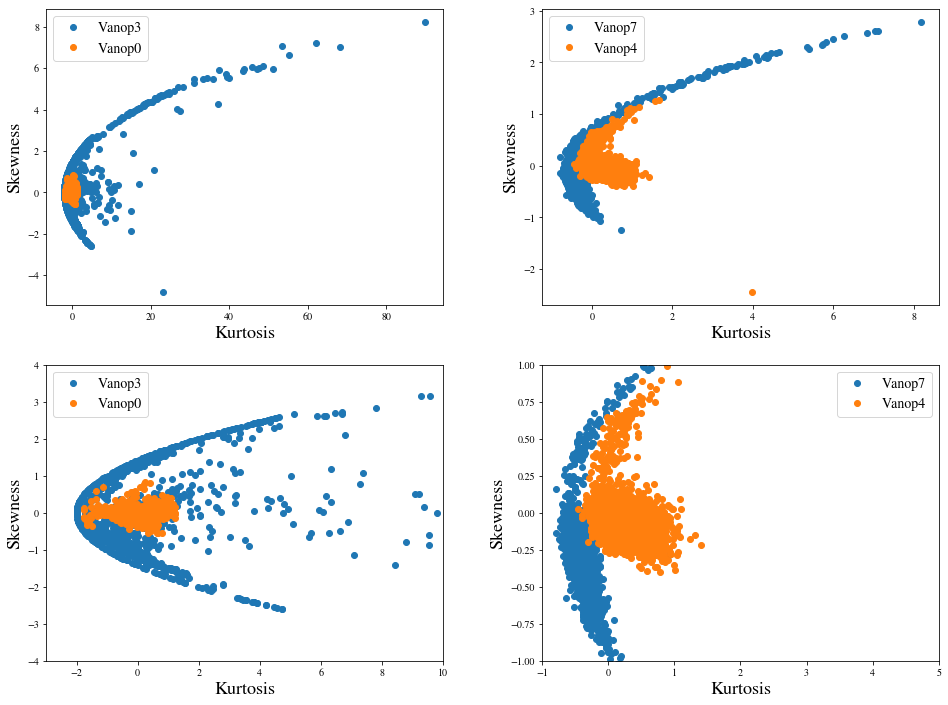

In [578]:
# Plot

# create a figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
# adjust the amount of width reserved for space between subplots
plt.subplots_adjust(wspace=0.25)
# fig.suptitle('Main title',fontsize = 18)
axs[0,0].plot(k3,s3,'o',label='Vanop3')
axs[0,0].plot(k0,s0,'o',label='Vanop0')

axs[0,1].plot(k7,s7,'o',label='Vanop7')
axs[0,1].plot(k4,s4,'o',label='Vanop4')

axs[0,0].set_xlabel('Kurtosis', fontsize = 18)
axs[0,0].set_ylabel('Skewness', fontsize = 18)
axs[0,0].legend(fontsize=14)

axs[0,1].set_xlabel('Kurtosis', fontsize = 18)
axs[0,1].set_ylabel('Skewness', fontsize = 18)
axs[0,1].legend(fontsize=14)


axs[1,0].plot(k3,s3,'o',label='Vanop3')
axs[1,0].plot(k0,s0,'o',label='Vanop0')
axs[1,1].plot(k7,s7,'o',label='Vanop7')
axs[1,1].plot(k4,s4,'o',label='Vanop4')

axs[1,0].set_xlabel('Kurtosis', fontsize = 18)
axs[1,0].set_ylabel('Skewness', fontsize = 18)
axs[1,0].legend(fontsize=14)

axs[1,1].set_xlabel('Kurtosis', fontsize = 18)
axs[1,1].set_ylabel('Skewness', fontsize = 18)
axs[1,1].legend(fontsize=14)

axs[1,1].set_ylim(-1, 1)
axs[1,1].set_xlim(-1, 5)

axs[1,0].set_ylim(-4, 4)
axs[1,0].set_xlim(-3, 10)

axs[1,1].set_ylim(-1, 1)
axs[1,1].set_xlim(-1, 5)

axs[1,0].set_ylim(-4, 4)
axs[1,0].set_xlim(-3, 10)



# axs[0,0].set_ylim(-2, 2)
# axs[0,0].set_xlim(-2, 4)

# axs[0,1].set_ylim(-7, 7)
# axs[0,1].set_xlim(-10, 50)

# axs[1,0].set_ylim(-4, 4)
# axs[1,0].set_xlim(-3, 10)
# axs[1,1].set_ylim(-1, 1)
# axs[1,1].set_xlim(-1, 5)

# axs[1,0].set_ylim(-4, 4)
# axs[1,0].set_xlim(-3, 10)

plt.savefig(hdf+' sn_'+str(session_num)+' threshold=10.png', format='png',dpi=120, bbox_inches="tight")

plt.show()




# Neural network part




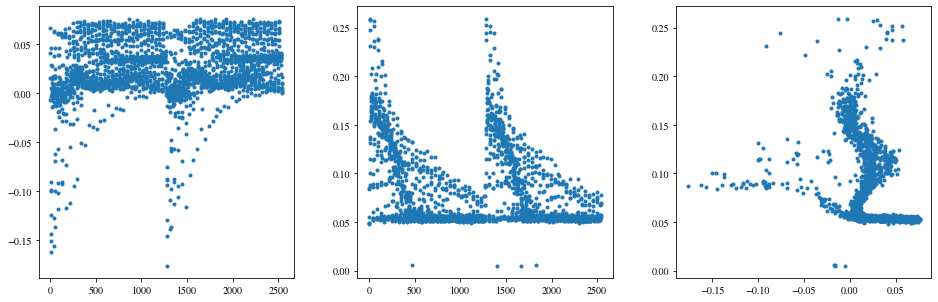

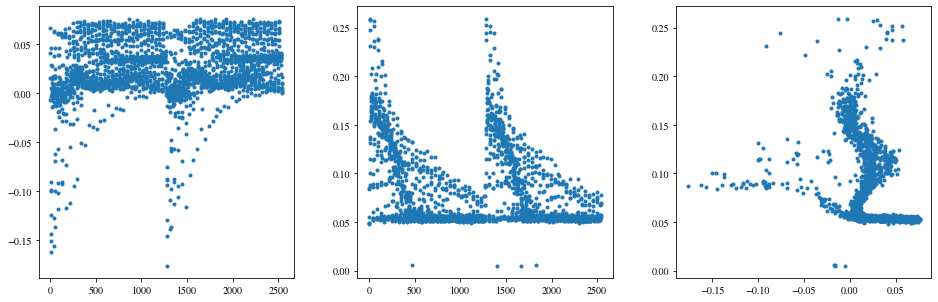

In [615]:
# plt.plot(Vanop,histograms4[600])
data = histograms0

Nhisto = len(data)

Mu = [ np.dot(Vanop,data[i]) for i in range(Nhisto) ]
Sigma = [ np.sqrt(np.dot(Vanop**2,data[i])-Mu[i]**2) for i in range(Nhisto) ]



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
plt.subplots_adjust(wspace=0.25)

axs[0].plot(Mu,'.')
axs[1].plot(Sigma,'.')
axs[2].plot(Mu,Sigma,'.')

data1 = [data[i] for i in range(Nhisto) if Sigma[i]>0.0]

data1=np.array(data1)

Nhisto1 = len(data1)

Mu1 = [ np.dot(Vanop,data1[i]) for i in range(Nhisto1) ]
Sigma1 = [ np.sqrt(np.dot(Vanop**2,data1[i])-Mu1[i]**2) for i in range(Nhisto1) ]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
plt.subplots_adjust(wspace=0.25)

axs[0].plot(Mu1,'.')
axs[1].plot(Sigma1,'.')
axs[2].plot(Mu1,Sigma1,'.')


In [616]:
muMn = min(Mu1)
muMx = max(Mu1)
muMx
bin_edges=np.append(Vanop-0.5*(Vanop[1]-Vanop[0]), Vanop[-1]+0.5*(Vanop[1]-Vanop[0]))
histo_counts.shape

(116, 20000)

In [651]:
# Generate learning samples

Nexamples    = 20000
Nsamples     = 1000

bincenters    = Vanop
bin_edges=np.append(Vanop-0.5*(Vanop[1]-Vanop[0]), Vanop[-1]+0.5*(Vanop[1]-Vanop[0]))
Nbins        = len(bincenters)
# 0.5*(bin_edges[:-1]+bin_edges[1:])
histo_counts = np.zeros((Nbins, Nexamples))

# muMn  = min(Mu1)
# muMx  = max(Mu1)
# sigMn = 0.001
# sigMx = 0.055

muMn  = -0.3
muMx  = 0.3
sigMn = 0.001
sigMx = 0.15


X = np.zeros((Nsamples, Nexamples))
Pars = np.random.uniform(0,1,(5, Nexamples)) # mu1 mu2 sig1 sig2 p1
Pars[0,:] = (muMx-muMn)*Pars[0,:]+muMn  # mu1
Pars[1,:] = (muMx-muMn)*Pars[1,:]+muMn  # mu2
Pars[2,:] = (sigMx-sigMn)*Pars[2,:]+sigMn  # mu1
Pars[3,:] = (sigMx-sigMn)*Pars[3,:]+sigMn  # mu2

G = np.random.normal(0,1,(Nsamples, Nexamples))
U = np.random.uniform(0,1,(Nsamples, Nexamples))
Y = np.zeros(( Nexamples))


for i in range(Nexamples):
    mu1, mu2, sig1, sig2, p1 = Pars[:,i]
    Y[i] = uni(mu1, mu2, sig1, sig2, p1)
    r = U[:,i]
    mu = mu1*(r<p1) + mu2*(r>=p1)
    sig = sig1*(r<p1) + sig2*(r>=p1)
    X[:,i] = mu+sig*G[:,1]
        
    counts, bin_edges = np.histogram(X[:,i], bins=bin_edges, density=  False)
    histo_counts[:,i] = counts
        

print('Mean Uni= '+str(np.mean(Y)))



Mean Uni= 0.51845


(20000, 116)
(14000, 116)
(14000,)
Epoch 1/500
438/438 [==============================] - 1s 735us/step - loss: 0.6686 - accuracy: 0.6012
Epoch 2/500
438/438 [==============================] - 0s 652us/step - loss: 0.5774 - accuracy: 0.7404
Epoch 3/500
438/438 [==============================] - 0s 633us/step - loss: 0.5071 - accuracy: 0.7681
Epoch 4/500
438/438 [==============================] - 0s 638us/step - loss: 0.4633 - accuracy: 0.7897
Epoch 5/500
438/438 [==============================] - 0s 637us/step - loss: 0.4422 - accuracy: 0.8005
Epoch 6/500
438/438 [==============================] - 0s 669us/step - loss: 0.4228 - accuracy: 0.8103
Epoch 7/500
438/438 [==============================] - 0s 634us/step - loss: 0.4091 - accuracy: 0.8214
Epoch 8/500
438/438 [==============================] - 0s 659us/step - loss: 0.4028 - accuracy: 0.8219
Epoch 9/500
438/438 [==============================] - 0s 668us/step - loss: 0.3927 - accuracy: 0.8239
Epoch 10/500
438/438 [================

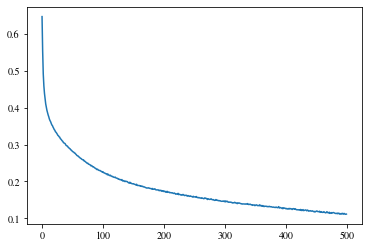

In [652]:
XX = histo_counts.T

Ntrain = int(Nexamples*0.7)

print(XX.shape)
train_images = XX[0:Ntrain,:]
test_images  = XX[Ntrain+1:,:]
train_labels = Y[0:Ntrain]
test_labels  = Y[Ntrain+1:]

# train_images.shape
train_images = train_images/Nsamples
test_images = test_images/Nsamples
print(train_images.shape)
print(train_labels.shape)


model = keras.Sequential([
#     keras.layers.Flatten(input_shape = (1,100)),
    keras.layers.Dense(100, activation=tf.nn.relu , input_shape = (Nbins,)),
#     keras.layers.Dense(100,activation=tf.nn.relu),
#     keras.layers.Dense(10,activation=tf.nn.softmax),
    keras.layers.Dense(2,activation=tf.nn.softmax)
])

model.compile(optimizer = "adam",
              loss="sparse_categorical_crossentropy",
             metrics = ["accuracy"])

history = model.fit(train_images, train_labels, epochs=500)

plt.plot(history.history['loss'])

In [653]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

188/188 [==============================] - 0s 519us/step - loss: 0.3437 - accuracy: 0.8910


Prediction: Unimodal   Actual: Unimodal 
[0.05361701 0.94638294]


(2542, 116)

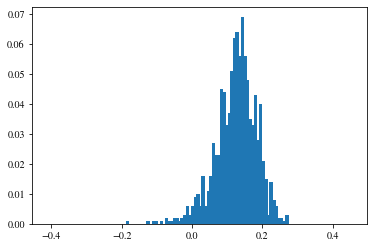

In [654]:
predictions = model.predict(test_images)

peaks = ['Bimodal', 'Unimodal']

# k = 17
k = 6
print(f"Prediction: {peaks[np.argmax(predictions[k])]}   Actual: {peaks[int(test_labels[k])]} ")

_=plt.bar(bincenters, test_images[k],0.01)
print(predictions[k])
data.shape

In [600]:
predictions

array([[0.02638964, 0.97361034],
       [0.01840648, 0.98159355],
       [0.0473286 , 0.9526714 ],
       ...,
       [0.02596886, 0.9740311 ],
       [0.00808291, 0.9919171 ],
       [0.01489034, 0.9851097 ]], dtype=float32)

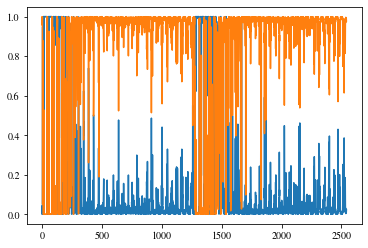

In [655]:
predictions = model.predict(data)
unif =[ np.argmax(p) for p in predictions ]
plt.plot(predictions)

In [656]:
idx = np.where(np.array(unif)==0)


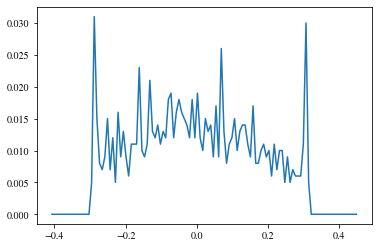

In [627]:
_=plt.plot(Vanop,data[idx[0][10]])

Prediction: Unimodal
[0.00144663 0.99855334]


(2542, 116)

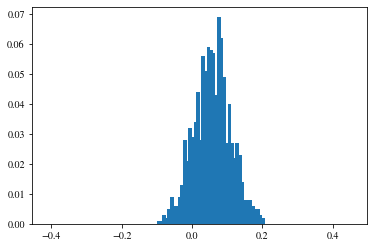

In [681]:

k=126
peaks = ['Bimodal', 'Unimodal']

print(f"Prediction: {peaks[np.argmax(predictions[k])]}")
_=plt.bar(bincenters, data[k],0.01)

print(predictions[k])
data.shape




In [557]:
idx = np.where(predictions[:,0]>0.9991)
idx

(array([  657,   660,   805,   806,   808,   931,   945,   960,  1088,
         1108,  1109,  1110,  1111,  1112,  1113,  1115,  1234,  1256,
         1257,  1259,  1260,  1261,  1263,  1409,  1410,  1412,  1413,
         1414,  1557,  1559,  1560,  1561,  1562,  1563,  1565,  1566,
         1568,  1690,  1706,  1710,  1711,  1712,  1713,  1714,  1715,
         1716,  1717,  1718,  1719,  1858,  1860,  1861,  1862,  1863,
         1864,  1865,  1866,  1867,  1868,  1869,  1870,  2294,  2442,
         2591,  3048,  3349,  3355,  3360,  3375,  3376,  3378,  3498,
         3499,  3529,  3530,  3674,  3680,  3810,  3829,  3830,  3833,
         3834,  5159,  5164,  5331,  5471,  5644,  5796,  5797,  6523,
         6823,  7280,  7733,  7739,  8488,  8783,  8950,  9693, 10593,
        10599, 10902, 11201, 11272, 11532, 11653, 12260, 12727, 12867,
        12870, 12875, 13028, 13033, 13166, 13188, 13463, 13468, 13620,
        13626, 13631, 13634, 13636, 13639, 13920, 14971, 15294, 15296,
      

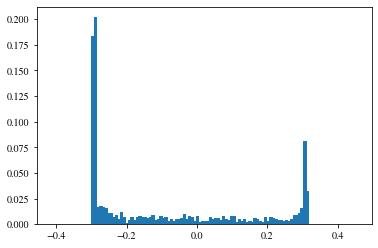

In [618]:
_=plt.bar(bincenters, data[idx[0][1]],0.01)

In [ ]:
_=plt.plot(data[idx[0][100]])